In [2]:
import argparse
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from scripts.lib import get_standards_characteristics, load_target_minerals, get_formula, load_images

def get_variable_percent(formula, n, epsilon=.0001):
    elements = [
        {'element': e, 'min': m[0], 'max': m[1]}
        for e, m in formula.items()
    ]

    base = sum([e['min'] for e in elements])
    remainder = 1 - base
    element_remainders = [e['max'] - e['min'] for e in elements]

    v = np.hstack([
        np.random.uniform(0, e, (n, 1)) for e in element_remainders
    ])

    while remainder > 0:
        s = v.sum(axis=1, keepdims=True)
        v = (v/s)*remainder
        mask = v < element_remainders
        r = np.clip(v - element_remainders, 0, None)
        v = v - r
        v = v + (mask * (r.sum(axis=1) / mask.sum(axis=1)).reshape(-1, 1))
        if np.abs(remainder - v.sum(axis=1)).mean() < epsilon:
            break

    return [(e['element'], e['min']+v[:, i]) for i, e in enumerate(elements)]

def simulate_mineral(mineral, formula, standard_elements, n=5):
    if not isinstance(formula, list):
        formula = [formula]

    #elements = []
    #masses = []

    mineral_elements = {}
    def append(element, mass):
        if element in mineral_elements:
            mineral_elements[element] += mass
        else:
            mineral_elements[element] = mass

    for component in formula:
        if isinstance(component, str):
            for element, mass in get_formula(component, format="mass").items():
                append(element, np.ones(n)*mass)
        elif isinstance(component, dict):
            if 'quantity' in component:
                quantity = component['quantity']
                if isinstance(quantity, list):
                    quantity = np.random.randint(quantity[0], quantity[1]+1)
            else:
                quantity = 1

            for molecule, percent in get_variable_percent(component['components'], n):
                for element, mass in get_formula(molecule, format="mass").items():
                    append(element, percent*mass*quantity)
        else:
            raise ValueError(f"{str(component)} is not a recognized format")

    # Calculate mass percents
    df = pd.DataFrame(mineral_elements)
    df.columns = [f"{element}_mass" for element in df.columns]
    df['mass'] = df.sum(axis=1)
    for element in mineral_elements:
        df[f"{element}_percent"] = df[f"{element}_mass"]/df['mass']

    # Convert to intensities
    for element in standard_elements:
        e = standard_elements[element]
        df[element] = (
            e['intercept'] + np.random.normal(scale=e['intercept'], size=n)
        )

        if f"{element}_percent" in df:
            df[element] += (
                e['coef']*df[f"{element}_percent"] +
                np.random.normal(scale=e['std'], size=n)
            )

        df[element] = np.clip(df[element], 0, None)


    '''mineral_elements = get_formula(component)
    for element, weight in mineral_elements.items():
        elements.append(element)
        masses.append(np.ones(n)*weight)'''

    df['mineral'] = mineral
    #df['formula'] = formula

    #return elements, masses
    return df





Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}
Training Classifier...
Training Accuracy: 0.9999545454545454
Testing Accuracy: 0.9999090909090909


No handles with labels found to put in legend.


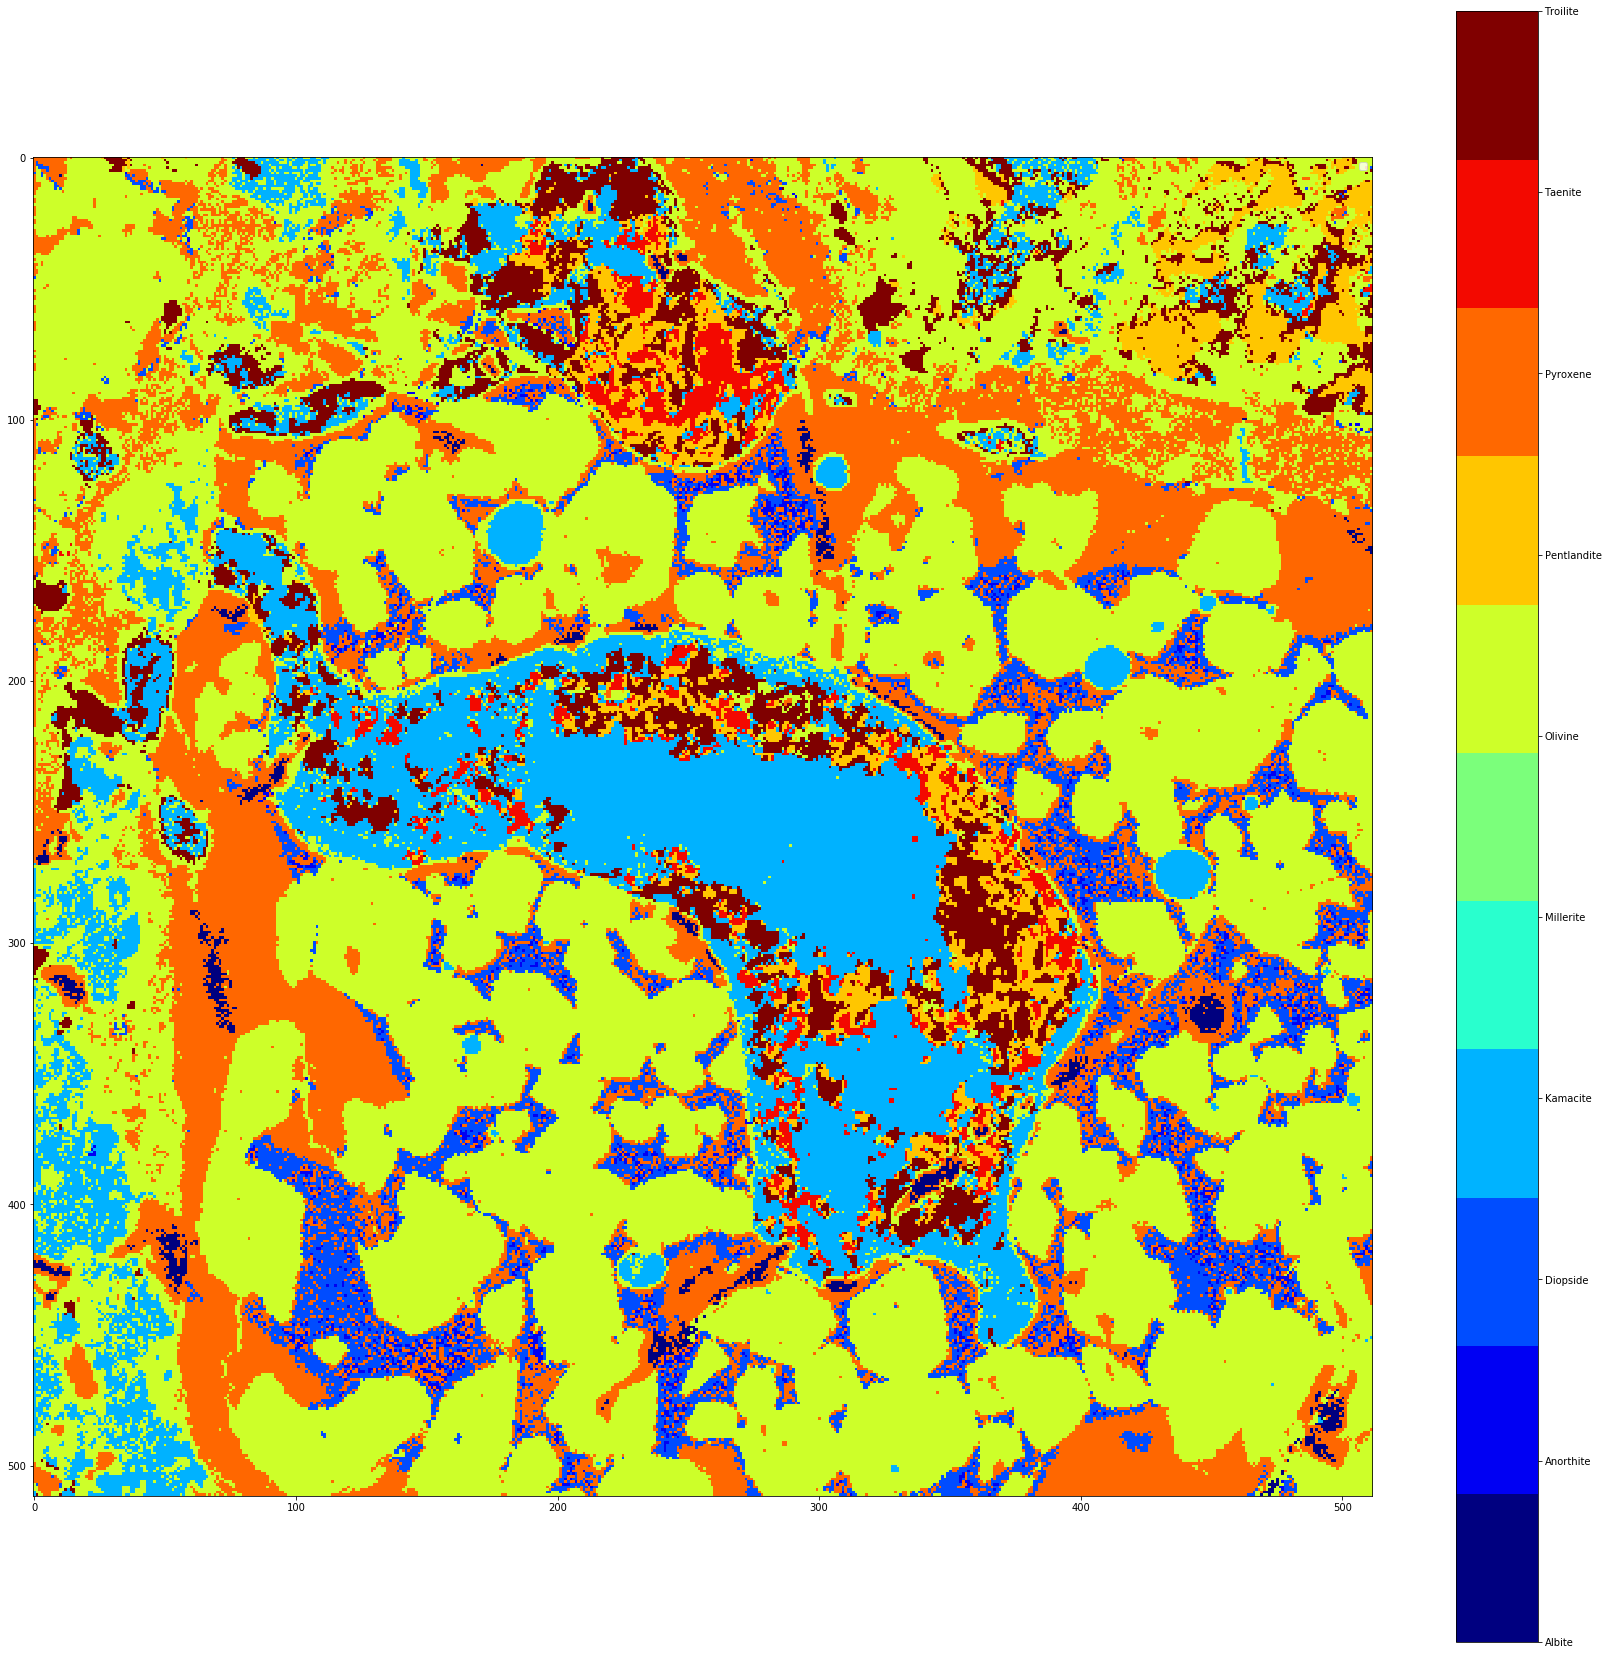

In [3]:
standards_dir = Path('challenge_data/dataset_1_opaques/standards/')
bits = 32
target_minerals_file = Path('challenge_data/dataset_1_opaques/target_minerals.yaml')
meteorite_dir = Path('challenge_data/dataset_1_opaques/obj1/')

characteristics = get_standards_characteristics(standards_dir, bits)
target_minerals = load_target_minerals(target_minerals_file)
#print(characteristics)
elements = list(characteristics.keys())
#

mineral_dfs = []
for mineral, formula in target_minerals.items():
    #print(mineral)

    df = simulate_mineral(mineral, formula, characteristics, 10000)
    #print(df.head())
    mineral_dfs.append(df[elements + ['mineral']])

df = pd.concat(mineral_dfs)

#print(len(df))
#print(df.head())

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

print("Training Classifier...")
model = RandomForestClassifier(100, max_depth=10, n_jobs=-1)
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)

#print(meteorite_df.head(20))
results = meteorite_df.merge(
    pd.Series(
        model.classes_, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(30,30))
i = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(model.classes_))
)
cbar = figure.colorbar(i, ticks=range(len(model.classes_)))
cbar.ax.set_yticklabels(model.classes_)
ax.legend()

#figure.savefig('test.png')

In [35]:
meteorite_df['mineral'].unique()

array(['Pyroxene', 'Olivine', 'Pentlandite', 'Troilite', 'Kamacite',
       'Diopside', 'Anorthite', 'Albite', 'Taenite'], dtype=object)

In [36]:
model.classes_

array(['Albite', 'Anorthite', 'Diopside', 'Kamacite', 'Millerite',
       'Olivine', 'Pentlandite', 'Pyroxene', 'Taenite', 'Troilite',
       'Wollastonite'], dtype=object)

In [37]:
minerals = meteorite_df['mineral'].unique()
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

In [32]:
i.norm(1)

0.1111111111111111

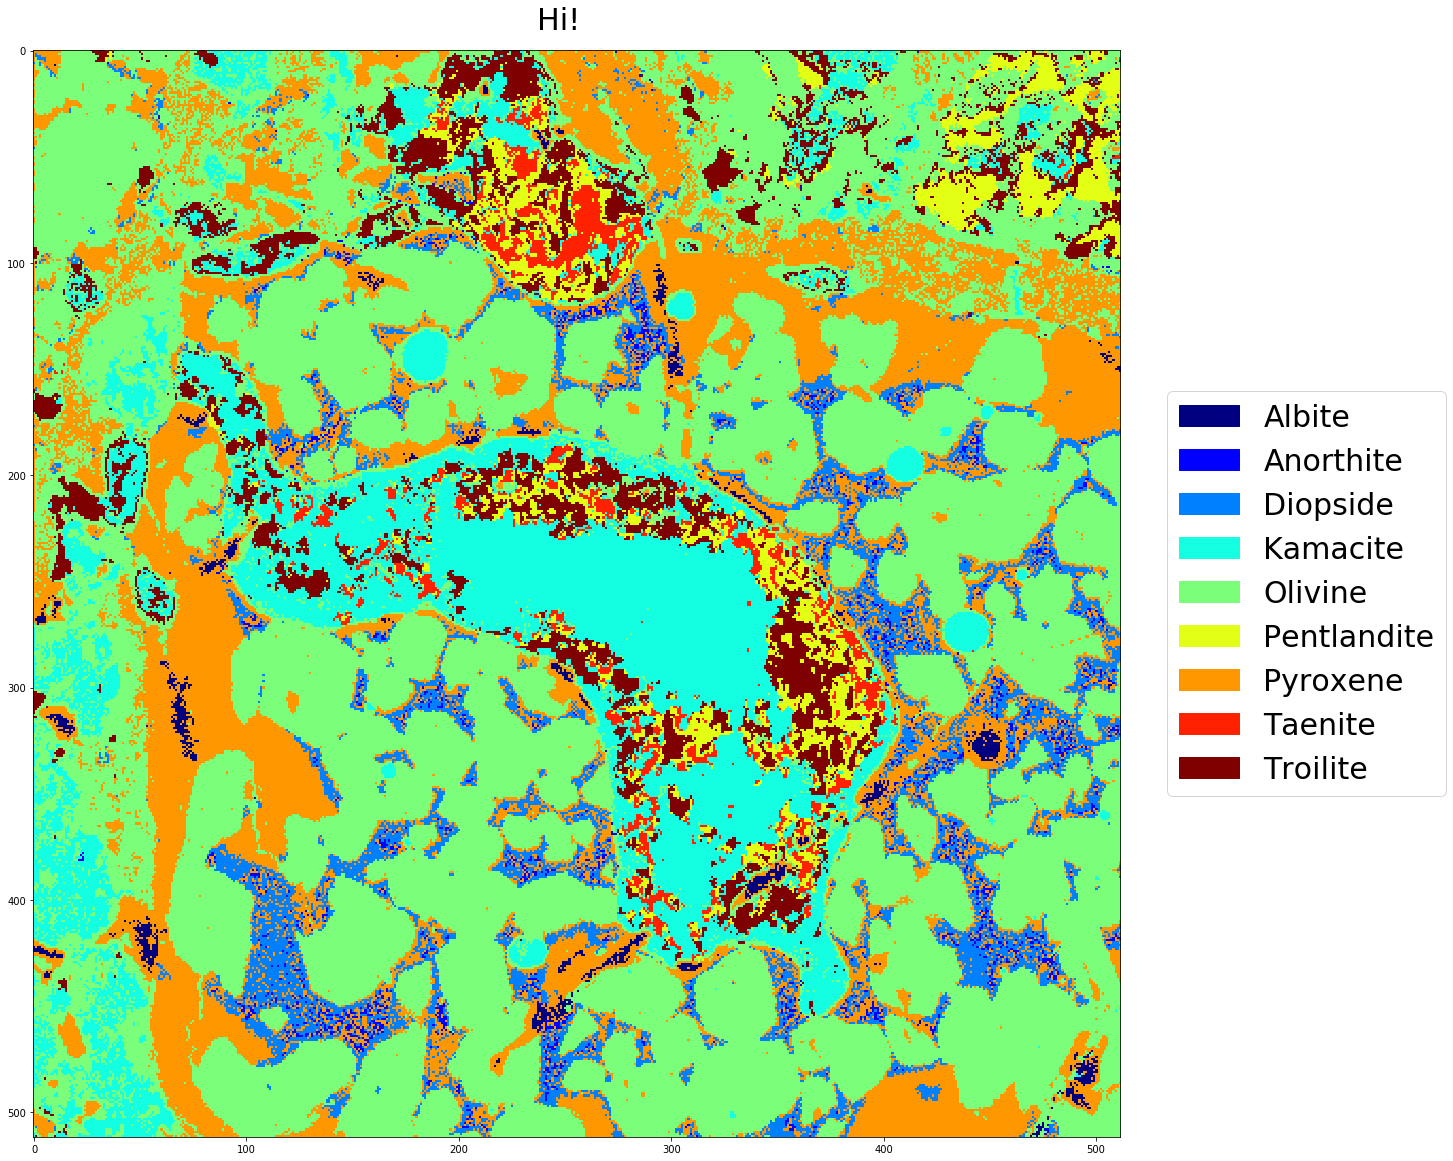

In [47]:
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

#cmap = plt.cm.get_cmap('jet', len(minerals))

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)

#cbar = figure.colorbar(i, ticks=range(len(model.classes_)))
#cbar.ax.set_yticklabels(model.classes_)
#ax.legend()

colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [ mpatches.Patch(color=colors[i], label=minerals[i]) for i in range(len(minerals)) ]
figure.suptitle('Hi!', fontsize=30, y=.91)
ax.legend(handles=patches, bbox_to_anchor=(1.3, .5, 0, 0), loc=5, borderaxespad=0., fontsize=30)

In [8]:
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=colors[i], label=model.classes_[i]) for i in range(len(model.classes_)) ]
patches